Machine Learning Component -- Cassie Chou and Julia Martin

In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import pickle
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
# Read in Data
calls_orig = pd.read_csv("911_Calls_for_Service_2024.csv")
calls_orig.head(5)


,callKey,callDateTime,priority,district,description,callNumber,incidentLocation,location,Neighborhood,PoliceDistrict,...,CouncilDistrict,SheriffDistricts,Community_Statistical_Areas,Census_Tracts,VRIZones,ZIPCode,NeedsSync,IsDeleted,HashedRecord,ESRI_OID
0,10CC9DA965929F12,2024/01/01 06:16:00+00,Non-Emergency,SE,NOISE COMPLAINT,P240011042,3600 PULASKI HY,3600 PULASKI HY BALTIMORE MD,Baltimore Highlands,Southeastern,...,1.0,D6,Orangeville/East Highlandtown,Census Tract 2604.04,NaN,21224.0,0,0,Kitomt4UpJkCoRg0jBbL41PKw1//fHtb9aCjz23s2A0=,1
1,10CC9DA96592A321,2024/01/01 06:33:00+00,Non-Emergency,ND,Private Tow,P240011065,5000 DENMORE AV,5000 DENMORE AV BALTIMORE MD,Central Park Heights,Northwestern,...,6.0,D1,Pimlico/Arlington/Hilltop,Census Tract 2718.02,Northwestern,21215.0,0,0,9AmT5HCrkqTZ8webGYDs+VbQDpTXZ0+lJyL3O+iQ5v4=,2
2,10CC9DA96592B7B9,2024/01/01 08:01:00+00,Non-Emergency,CD,PRKG COMPLAINT,P240011183,1400 ANCHOR ST,1400 ANCHOR ST BALTIMORE MD,Riverside,Southern,...,11.0,D7,Inner Harbor/Federal Hill,Census Tract 2402,NaN,21230.0,0,0,WHIVLB5k+BOGyUmlCPUzCKKr4Bg4f6S4NwrvbgqMkZ0=,3
3,10CC9DA96592BCBA,2024/01/01 08:23:00+00,Non-Emergency,CD,PRKG COMPLAINT,P240011224,1900 EASTERN AV,1900 EASTERN AV BALTIMORE MD,Fells Point,Southeastern,...,1.0,D6,Fells Point,Census Tract 203,NaN,21231.0,0,0,Bvouy/qh83Ejj/1V3Q0AuFs3tnChlZAY4lYsW0Korrs=,4
4,10CC9DA96592DFE2,2024/01/01 10:53:00+00,Low,SD,CHECK WELL-BEING,P240011605,1600 MARSHALL ST,1600 MARSHALL ST BALTIMORE MD,South Baltimore,Southern,...,11.0,D7,Inner Harbor/Federal Hill,Census Tract 2302,NaN,21230.0,0,0,Jo2YzEoa5g+q9cmpQdYzipvP3sQxBYSXg95Rd/97RdM=,5


In [3]:
# Select relevant columns
calls = calls_orig[['callDateTime', 'priority', 'description', 'incidentLocation', 'Neighborhood', 'district', 'Community_Statistical_Areas']]
calls.dropna(inplace=True)

# Encode categorical variables
priority_order = ['Non-Emergency', 'Low', 'Medium', 'High', 'Emergency', 'Out of Service']
le_priority = LabelEncoder()
le_priority.classes_ = np.array(priority_order)
calls['priority'] = le_priority.transform(calls['priority'])

le_csa = OneHotEncoder(sparse_output=False, drop = None)
csa_encoded = le_csa.fit_transform(calls[['Community_Statistical_Areas']])

le_neighborhood = OneHotEncoder(sparse_output=False, drop = None)
neighborhood_encoded = le_neighborhood.fit_transform(calls[['Neighborhood']])
neighborhood_encoded = pd.DataFrame(neighborhood_encoded, columns=le_neighborhood.categories_, index=calls.index)

# Encode Descriptions (need to only do top 50 since there are over 1000 unique values)
# Get top 50 most frequent categories
top_n = 50
top_categories = calls['description'].value_counts().nlargest(top_n).index.tolist()

# Create encoded column
calls['description_encoded'] = np.where(
    calls['description'].isin(top_categories),
    calls['description'],
    'Other'
)

# Now one-hot encode
le_description = OneHotEncoder(sparse_output=False, drop = None)
descrip_encoded = le_description.fit_transform(calls[['description_encoded']])
descrip_encoded = pd.DataFrame(descrip_encoded, columns=le_description.categories_, index=calls.index)

# Join back to calls dataframe
calls = calls.join(neighborhood_encoded)
calls = calls.join(descrip_encoded)

# Convert callDateTime to Month, Day, time format
calls['callDateTime'] = pd.to_datetime(calls['callDateTime'], format="%Y/%m/%d %H:%M:%S%z")
calls["month"] = calls["callDateTime"].dt.month       # 1 (int)
calls["day"] = calls["callDateTime"].dt.day           # 1 (int)
calls["time"] = calls["callDateTime"].dt.strftime('%H%M%S').astype(int)
calls["day_of_week"] = calls["callDateTime"].dt.dayofweek

calls.head(5)

C:\Users\Home2\AppData\Local\Temp\ipykernel_12004\2606962332.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls.dropna(inplace=True)
C:\Users\Home2\AppData\Local\Temp\ipykernel_12004\2606962332.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['priority'] = le_priority.transform(calls['priority'])
C:\Users\Home2\AppData\Local\Temp\ipykernel_12004\2606962332.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

,callDateTime,priority,description,incidentLocation,Neighborhood,district,Community_Statistical_Areas,description_encoded,"(Abell,)","(Allendale,)",...,"(SUSPICIOUS PERS,)","(Traffic Stop,)","(Transport,)","(VEHICLE DISTURB,)","(WANTED ON WARR,)","(Warrant Service,)",month,day,time,day_of_week
0,2024-01-01 06:16:00+00:00,0,NOISE COMPLAINT,3600 PULASKI HY,Baltimore Highlands,SE,Orangeville/East Highlandtown,NOISE COMPLAINT,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,61600,0
1,2024-01-01 06:33:00+00:00,0,Private Tow,5000 DENMORE AV,Central Park Heights,ND,Pimlico/Arlington/Hilltop,Private Tow,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,63300,0
2,2024-01-01 08:01:00+00:00,0,PRKG COMPLAINT,1400 ANCHOR ST,Riverside,CD,Inner Harbor/Federal Hill,PRKG COMPLAINT,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,80100,0
3,2024-01-01 08:23:00+00:00,0,PRKG COMPLAINT,1900 EASTERN AV,Fells Point,CD,Fells Point,PRKG COMPLAINT,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,82300,0
4,2024-01-01 10:53:00+00:00,1,CHECK WELL-BEING,1600 MARSHALL ST,South Baltimore,SD,Inner Harbor/Federal Hill,CHECK WELL-BEING,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,105300,0


Prepare Data for Machine Learning

In [4]:
n = calls.shape[0]

np.random.seed(37)
# Split into Train/Test Fraction
trainFraction = 0.6
sample = np.random.uniform(size = n) < trainFraction
train_data = calls[sample]
test_data = calls[~sample]

valFraction = 0.5
valSample = np.random.uniform(size = test_data.shape[0]) < valFraction
val_data = test_data[valSample]
test_data = test_data[~valSample]

# Standardize Data
features = ['month', 'day', 'time']
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
val_data[features] = scaler.transform(val_data[features])

# X Train/Test/Val
pred_columns = calls.columns[8:]
X_train = torch.from_numpy(train_data[pred_columns].values.astype(np.float32))
X_test = torch.from_numpy(test_data[pred_columns].values.astype(np.float32))
X_val = torch.from_numpy(val_data[pred_columns].values.astype(np.float32))

# Y Train/Test/Val
Y_train = torch.tensor(train_data['priority'].values, dtype=torch.long)
Y_val = torch.tensor(val_data['priority'].values, dtype=torch.long)
Y_test = test_data['priority'].values

# Create Weights
class_counts = np.bincount(Y_train.numpy())
weights = 1 / np.sqrt(class_counts)

# Normalize weights
weights = weights / weights.sum() * len(weights)
class_weights_tensor = torch.tensor(weights, dtype=torch.float32)


C:\Users\Home2\AppData\Local\Temp\ipykernel_12004\3552332615.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[features] = scaler.fit_transform(train_data[features])


In [4]:
# Prep Model
# Define Model (2 Layers, 256, 128 nodes each)
class EnhancedPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(256, 128),
            nn.LayerNorm(128),
            nn.LeakyReLU(0.2),

            nn.Linear(128, 6)
        )
        
    def forward(self, x):
        return self.net(x)
    
model = EnhancedPredictor(input_size=X_train.shape[1])
print(model)

EnhancedPredictor(
  (net): Sequential(
    (0): Linear(in_features=281, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=256, out_features=128, bias=True)
    (5): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Linear(in_features=128, out_features=6, bias=True)
  )
)


In [5]:
# Define Focal Loss for Unbalanced Data
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=1.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        # Standard cross entropy
        ce_loss = F.cross_entropy(inputs, targets, 
                                weight=self.alpha, 
                                reduction='none')
        
        # Focal Loss adjustment
        pt = torch.exp(-ce_loss)  # Softmax probability of true class
        focal_loss = (1 - pt)**self.gamma * ce_loss
        
        return focal_loss.mean()

In [7]:
# Loss and optimizer
criterion = FocalLoss(alpha=class_weights_tensor, gamma=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1) 

set_seed = 42
torch.manual_seed(set_seed)
# Train for 10 epochs
epochs = 25
for epoch in range(epochs):
    # Training
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    
    # Validation
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad(): 
        val_outputs = model(X_val)
        val_loss = criterion(val_outputs, Y_val)
        predicted = torch.argmax(val_outputs, dim = 1)
        correct = (predicted == Y_val).sum().item()
        total = Y_val.size(0)
    val_acc = correct / total

    # Slow Learning Rate if Validation Loss does not improve
    scheduler.step(val_loss) 
    
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f},  Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')


Epoch 1, Loss: 0.0120,  Val Loss = 0.0099, Val Acc = 0.5267
Epoch 2, Loss: 0.0096,  Val Loss = 0.0085, Val Acc = 0.4228
Epoch 3, Loss: 0.0083,  Val Loss = 0.0077, Val Acc = 0.4319
Epoch 4, Loss: 0.0075,  Val Loss = 0.0071, Val Acc = 0.4986
Epoch 5, Loss: 0.0069,  Val Loss = 0.0066, Val Acc = 0.6292
Epoch 6, Loss: 0.0064,  Val Loss = 0.0061, Val Acc = 0.7769
Epoch 7, Loss: 0.0060,  Val Loss = 0.0058, Val Acc = 0.8490
Epoch 8, Loss: 0.0056,  Val Loss = 0.0055, Val Acc = 0.8705
Epoch 9, Loss: 0.0053,  Val Loss = 0.0053, Val Acc = 0.8779
Epoch 10, Loss: 0.0049,  Val Loss = 0.0050, Val Acc = 0.8836
Epoch 11, Loss: 0.0046,  Val Loss = 0.0048, Val Acc = 0.8922
Epoch 12, Loss: 0.0043,  Val Loss = 0.0045, Val Acc = 0.9034
Epoch 13, Loss: 0.0040,  Val Loss = 0.0041, Val Acc = 0.9147
Epoch 14, Loss: 0.0037,  Val Loss = 0.0038, Val Acc = 0.9238
Epoch 15, Loss: 0.0034,  Val Loss = 0.0034, Val Acc = 0.9288
Epoch 16, Loss: 0.0031,  Val Loss = 0.0031, Val Acc = 0.9300
Epoch 17, Loss: 0.0029,  Val Loss

In [8]:
# Make Predictions on Test Data
model.eval()
with torch.no_grad():
    logits = model(X_test)
    probs = torch.softmax(logits, dim = 1)
    preds = torch.argmax(probs, dim = 1)


In [9]:
# Get Counts of Each Prediction Class
preds_labeled = pd.DataFrame(le_priority.inverse_transform(preds.numpy()))
print(preds_labeled.value_counts())

# Get Counts of Each Class in Test Data
counts_test = pd.DataFrame(le_priority.inverse_transform(Y_test))
print(counts_test.value_counts())

# Counts of Each Class in Original Data
category_counts = pd.DataFrame(le_priority.inverse_transform(calls['priority'])).value_counts()
print(category_counts)

0             
Non-Emergency     212968
Low                55341
Medium             36076
High               15044
Emergency          10304
Out of Service       932
Name: count, dtype: int64
0             
Non-Emergency     221207
Low                56049
Medium             42682
High               10665
Emergency             40
Out of Service        22
Name: count, dtype: int64
0             
Non-Emergency     1108319
Low                278622
Medium             213392
High                53479
Emergency             256
Out of Service        106
Name: count, dtype: int64


In [10]:
# Get Accuracy on Testing Set
print(np.mean(preds.numpy() == Y_test))

# Get Accuracy for Points who's Descriptions are not in the Top 50
not_top_50 = np.isin(test_data['description'], top_categories, invert=True)
X_not50 = torch.from_numpy(test_data[not_top_50][pred_columns].values.astype(np.float32))
Y_not50 = test_data[not_top_50]['priority']

model.eval()
with torch.no_grad():
    logits_not50 = model(X_not50)
    probs_not50 = torch.softmax(logits_not50, dim = 1)
    preds_not50 = torch.argmax(probs_not50, dim = 1)

print(np.mean(preds_not50.numpy() == Y_not50))


0.9255349069299744
0.13323464100666174


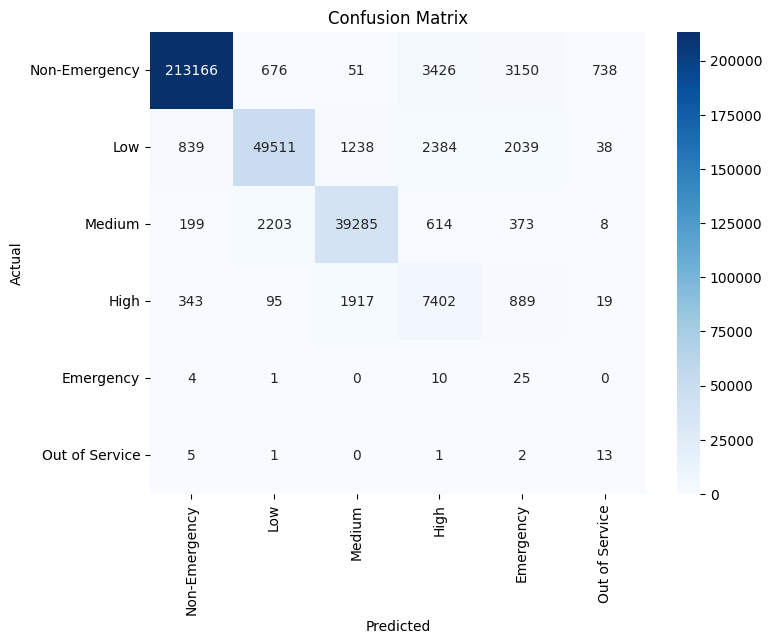

In [ ]:
# Plot and generate the confusion matrix
y_true = Y_test
y_pred = preds.numpy()

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_priority.classes_, 
            yticklabels=le_priority.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight') 
plt.show()

In [ ]:
# Export Model and Preprocessors
with open('priority_model.pkl', 'wb') as f:
    pickle.dump(model, f)

with open('preprocessors.pkl', 'wb') as f:
    pickle.dump({'scaler': scaler, 'le_priority': le_priority, 'le_csa' : le_csa, 'le_neighborhood' : le_neighborhood, 'le_description' : le_description}, f)

In [ ]:
# Get Possible CSA, Neighborhood, and Description Values
'''
csa_values = le_csa.categories_[0].tolist()
neighborhood_values = le_neighborhood.categories_[0].tolist()
description_values = le_description.categories_[0].tolist()

# Save to CSV
csa_df = pd.DataFrame(csa_values, columns=['Community_Statistical_Areas'])
csa_df.to_csv('csa.csv', index=False)
neighborhood_df = pd.DataFrame(neighborhood_values, columns=['Neighborhood'])
neighborhood_df.to_csv('neighborhood.csv', index=False)
description_df = pd.DataFrame(description_values, columns=['Description'])
description_df.to_csv('description.csv', index=False)
'''

"\ncsa_values = le_csa.categories_[0].tolist()\nneighborhood_values = le_neighborhood.categories_[0].tolist()\ndescription_values = le_description.categories_[0].tolist()\n\n# Save to CSV\ncsa_df = pd.DataFrame(csa_values, columns=['Community_Statistical_Areas'])\ncsa_df.to_csv('csa.csv', index=False)\nneighborhood_df = pd.DataFrame(neighborhood_values, columns=['Neighborhood'])\nneighborhood_df.to_csv('neighborhood.csv', index=False)\ndescription_df = pd.DataFrame(description_values, columns=['Description'])\ndescription_df.to_csv('description.csv', index=False)\n"

Predict Non-Emergency or Not Non-Emergency

In [ ]:
# Select relevant columns
calls2 = calls_orig[['callDateTime', 'priority', 'description', 'Neighborhood']]
calls2.dropna(inplace=True)

# Encode categorical variables
non_emergency_terms = ['Non-Emergency', 'Out of Service']

calls2['priority_binary'] = np.where(
    calls2['priority'].isin(non_emergency_terms),
    'Non-Emergency',
    'Urgent'
)

le_priority_binary = LabelEncoder()
calls2['priority_binary'] = le_priority_binary.fit_transform(calls2['priority_binary'])

le_neighborhood2 = OneHotEncoder(sparse_output=False, drop = None)
neighborhood_encoded2 = le_neighborhood2.fit_transform(calls2[['Neighborhood']])
neighborhood_encoded2 = pd.DataFrame(neighborhood_encoded2, columns=le_neighborhood2.categories_, index=calls2.index)

# Join back to calls dataframe
calls2 = calls2.join(neighborhood_encoded)

# Convert callDateTime to Month, Day, time format
calls2['callDateTime'] = pd.to_datetime(calls2['callDateTime'], format="%Y/%m/%d %H:%M:%S%z")
calls2["month"] = calls2["callDateTime"].dt.month       # 1 (int)
calls2["day"] = calls2["callDateTime"].dt.day           # 1 (int)
calls2["time"] = calls2["callDateTime"].dt.strftime('%H%M%S').astype(int)
calls2["day_of_week"] = calls2["callDateTime"].dt.dayofweek

calls2.dropna(inplace=True)
calls2.head(5)

C:\Users\Home2\AppData\Local\Temp\ipykernel_5756\3542283407.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls2.dropna(inplace=True)
C:\Users\Home2\AppData\Local\Temp\ipykernel_5756\3542283407.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls2['priority_binary'] = np.where(
C:\Users\Home2\AppData\Local\Temp\ipykernel_5756\3542283407.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org

,callDateTime,priority,description,Neighborhood,priority_binary,"(Abell,)","(Allendale,)","(Arcadia,)","(Arlington,)","(Armistead Gardens,)",...,"(Woodmere,)","(Wrenlane,)","(Wyman Park,)","(Wyndhurst,)","(Yale Heights,)","(York-Homeland,)",month,day,time,day_of_week
0,2024-01-01 06:16:00+00:00,Non-Emergency,NOISE COMPLAINT,Baltimore Highlands,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,61600,0
1,2024-01-01 06:33:00+00:00,Non-Emergency,Private Tow,Central Park Heights,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,63300,0
2,2024-01-01 08:01:00+00:00,Non-Emergency,PRKG COMPLAINT,Riverside,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,80100,0
3,2024-01-01 08:23:00+00:00,Non-Emergency,PRKG COMPLAINT,Fells Point,0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,82300,0
4,2024-01-01 10:53:00+00:00,Low,CHECK WELL-BEING,South Baltimore,1,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,1,105300,0


In [ ]:
n = calls2.shape[0]

np.random.seed(151)
# Split into Train/Test Fraction
trainFraction = 0.6
sample = np.random.uniform(size = n) < trainFraction
train_data2 = calls2[sample]
test_data2 = calls2[~sample]

valFraction = 0.5
valSample = np.random.uniform(size = test_data2.shape[0]) < valFraction
val_data2 = test_data2[valSample]
test_data2 = test_data2[~valSample]

# Standardize Data
features = ['month', 'day', 'time']
scaler = StandardScaler()
train_data2[features] = scaler.fit_transform(train_data2[features])
test_data2[features] = scaler.transform(test_data2[features])
val_data2[features] = scaler.transform(val_data2[features])

# X Train/Test/Val
pred_columns = calls2.columns[5:]
X_train2 = torch.from_numpy(train_data2[pred_columns].values.astype(np.float32))
X_test2 = torch.from_numpy(test_data2[pred_columns].values.astype(np.float32))
X_val2 = torch.from_numpy(val_data2[pred_columns].values.astype(np.float32))

# Y Train/Test/Val
Y_train2 = torch.tensor(train_data2['priority_binary'].values, dtype=torch.long)
Y_val2 = torch.tensor(val_data2['priority_binary'].values, dtype=torch.long)
Y_test2 = test_data2['priority_binary'].values


C:\Users\Home2\AppData\Local\Temp\ipykernel_5756\2864131897.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2[features] = scaler.fit_transform(train_data2[features])


In [ ]:
class BinaryPredictor(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.LayerNorm(64),
            nn.LeakyReLU(0.2),

            nn.Linear(64, 2)
        )
        
    def forward(self, x):
        return self.net(x)
    
model2 = BinaryPredictor(input_size=X_train2.shape[1])
print(model2)

BinaryPredictor(
  (net): Sequential(
    (0): Linear(in_features=282, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (6): LeakyReLU(negative_slope=0.2)
    (7): Linear(in_features=64, out_features=2, bias=True)
  )
)


In [ ]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1) 

set_seed = 42
torch.manual_seed(set_seed)
# Train for 10 epochs
epochs = 25
for epoch in range(epochs):
    # Training
    model2.train()
    optimizer.zero_grad()
    outputs = model2(X_train2)
    loss = criterion(outputs, Y_train2)
    loss.backward()
    optimizer.step()
    
    # Validation
    model2.eval()
    correct = 0
    total = 0

    with torch.no_grad(): 
        val_outputs = model2(X_val2)
        val_loss = criterion(val_outputs, Y_val2)
        predicted = torch.argmax(val_outputs, dim = 1)
        correct = (predicted == Y_val2).sum().item()
        total = Y_val2.size(0)
    val_acc = correct / total

    # Slow Learning Rate if Validation Loss does not improve
    scheduler.step(val_loss) 
    
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f},  Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')
    

Epoch 1, Loss: 0.6832,  Val Loss = 0.6390, Val Acc = 0.6695
Epoch 2, Loss: 0.6488,  Val Loss = 0.6410, Val Acc = 0.6695
Epoch 3, Loss: 0.6334,  Val Loss = 0.6395, Val Acc = 0.6695
Epoch 4, Loss: 0.6292,  Val Loss = 0.6377, Val Acc = 0.6695
Epoch 5, Loss: 0.6294,  Val Loss = 0.6368, Val Acc = 0.6695
Epoch 6, Loss: 0.6292,  Val Loss = 0.6359, Val Acc = 0.6695
Epoch 7, Loss: 0.6270,  Val Loss = 0.6340, Val Acc = 0.6695
Epoch 8, Loss: 0.6229,  Val Loss = 0.6309, Val Acc = 0.6695
Epoch 9, Loss: 0.6185,  Val Loss = 0.6272, Val Acc = 0.6695
Epoch 10, Loss: 0.6143,  Val Loss = 0.6234, Val Acc = 0.6694
Epoch 11, Loss: 0.6109,  Val Loss = 0.6197, Val Acc = 0.6695
Epoch 12, Loss: 0.6090,  Val Loss = 0.6163, Val Acc = 0.6694
Epoch 13, Loss: 0.6080,  Val Loss = 0.6132, Val Acc = 0.6695
Epoch 14, Loss: 0.6071,  Val Loss = 0.6105, Val Acc = 0.6695
Epoch 15, Loss: 0.6063,  Val Loss = 0.6084, Val Acc = 0.6695
Epoch 16, Loss: 0.6057,  Val Loss = 0.6068, Val Acc = 0.6696
Epoch 17, Loss: 0.6046,  Val Loss

In [ ]:
# Make Predictions on Test Data
model2.eval()
with torch.no_grad():
    logits2 = model2(X_test2)
    probs2 = torch.softmax(logits2, dim = 1)
    preds2 = torch.argmax(probs2, dim = 1)

# Get Counts of Each Prediction Class
preds_labeled2 = pd.DataFrame(le_priority_binary.inverse_transform(preds2.numpy()))
print(preds_labeled2.value_counts())

# Get Counts of Each Class in Test Data
counts_test2 = pd.DataFrame(le_priority_binary.inverse_transform(Y_test2))
print(counts_test2.value_counts())

# Counts of Each Class in Original Data
category_counts2 = pd.DataFrame(le_priority_binary.inverse_transform(calls2['priority_binary'])).value_counts()
print(category_counts2)

# Get Accuracy on Testing Set
np.mean(preds2.numpy() == Y_test2)

0            
Non-Emergency    312000
Urgent            19475
Name: count, dtype: int64
0            
Non-Emergency    221617
Urgent           109858
Name: count, dtype: int64
0            
Non-Emergency    1108425
Urgent            545749
Name: count, dtype: int64


0.6769258616788596

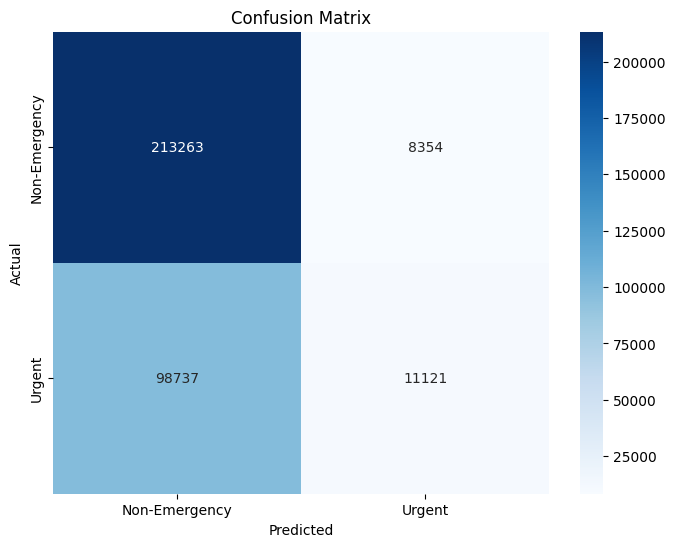

In [ ]:
# Plot and generate the confusion matrix
y_true2 = Y_test2
y_pred2 = preds2.numpy()

# Generate confusion matrix
cm2 = confusion_matrix(y_true2, y_pred2)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_priority_binary.classes_, 
            yticklabels=le_priority_binary.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Trying Upweighting of Urgent Calls in the Binary Model

In [ ]:
# Create Weights
class_counts2 = np.bincount(Y_train2.numpy())
weights2 = 1 / np.sqrt(class_counts2)

# Normalize weights
weights2 = weights2 / weights2.sum() * len(weights2)
class_weights_tensor2 = torch.tensor(weights2, dtype=torch.float32)

In [ ]:
model3 = BinaryPredictor(input_size=X_train2.shape[1])

# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor2)
optimizer = torch.optim.Adam(model3.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1) 

set_seed = 42
torch.manual_seed(set_seed)
# Train for 10 epochs
epochs = 25
for epoch in range(epochs):
    # Training
    model2.train()
    optimizer.zero_grad()
    outputs = model3(X_train2)
    loss = criterion(outputs, Y_train2)
    loss.backward()
    optimizer.step()
    
    # Validation
    model2.eval()
    correct = 0
    total = 0

    with torch.no_grad(): 
        val_outputs = model3(X_val2)
        val_loss = criterion(val_outputs, Y_val2)
        predicted = torch.argmax(val_outputs, dim = 1)
        correct = (predicted == Y_val2).sum().item()
        total = Y_val2.size(0)
    val_acc = correct / total

    # Slow Learning Rate if Validation Loss does not improve
    scheduler.step(val_loss) 
    
    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f},  Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')

Epoch 1, Loss: 0.7132,  Val Loss = 0.6882, Val Acc = 0.6209
Epoch 2, Loss: 0.6878,  Val Loss = 0.6756, Val Acc = 0.6350
Epoch 3, Loss: 0.6750,  Val Loss = 0.6712, Val Acc = 0.6295
Epoch 4, Loss: 0.6700,  Val Loss = 0.6692, Val Acc = 0.6264
Epoch 5, Loss: 0.6680,  Val Loss = 0.6671, Val Acc = 0.6285
Epoch 6, Loss: 0.6658,  Val Loss = 0.6640, Val Acc = 0.6323
Epoch 7, Loss: 0.6626,  Val Loss = 0.6605, Val Acc = 0.6396
Epoch 8, Loss: 0.6590,  Val Loss = 0.6568, Val Acc = 0.6466
Epoch 9, Loss: 0.6554,  Val Loss = 0.6537, Val Acc = 0.6532
Epoch 10, Loss: 0.6522,  Val Loss = 0.6510, Val Acc = 0.6597
Epoch 11, Loss: 0.6496,  Val Loss = 0.6494, Val Acc = 0.6643
Epoch 12, Loss: 0.6480,  Val Loss = 0.6482, Val Acc = 0.6669
Epoch 13, Loss: 0.6467,  Val Loss = 0.6472, Val Acc = 0.6680
Epoch 14, Loss: 0.6457,  Val Loss = 0.6460, Val Acc = 0.6686
Epoch 15, Loss: 0.6445,  Val Loss = 0.6450, Val Acc = 0.6693
Epoch 16, Loss: 0.6435,  Val Loss = 0.6435, Val Acc = 0.6702
Epoch 17, Loss: 0.6423,  Val Loss

In [ ]:
model3.eval()
with torch.no_grad():
    logits3 = model3(X_test2)
    probs3 = torch.softmax(logits3, dim = 1)
    preds3 = torch.argmax(probs3, dim = 1)

# Get Counts of Each Prediction Class
preds_labeled3 = pd.DataFrame(le_priority_binary.inverse_transform(preds3.numpy()))
print(preds_labeled3.value_counts())

# Get Counts of Each Class in Test Data
counts_test2 = pd.DataFrame(le_priority_binary.inverse_transform(Y_test2))
print(counts_test2.value_counts())

# Counts of Each Class in Original Data
category_counts2 = pd.DataFrame(le_priority_binary.inverse_transform(calls2['priority_binary'])).value_counts()
print(category_counts2)

# Get Accuracy on Testing Set
np.mean(preds3.numpy() == Y_test2)

0            
Non-Emergency    240613
Urgent            90862
Name: count, dtype: int64
0            
Non-Emergency    221617
Urgent           109858
Name: count, dtype: int64
0            
Non-Emergency    1108425
Urgent            545749
Name: count, dtype: int64


0.6745154234859341

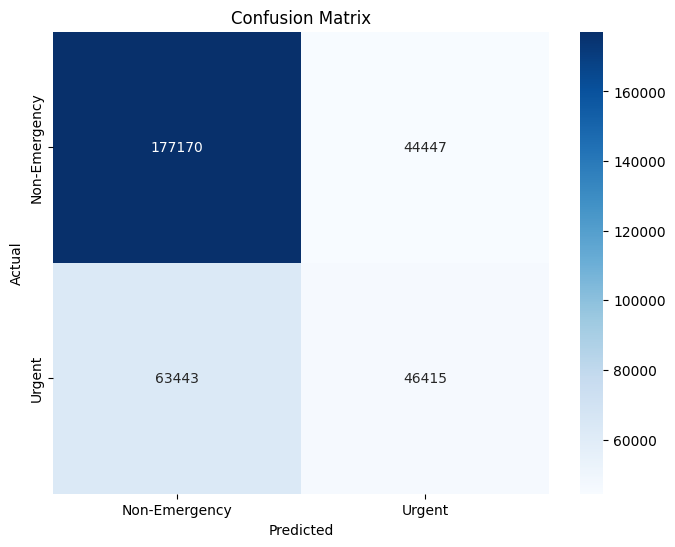

In [ ]:
# Plot and generate the confusion matrix
y_true3 = Y_test2
y_pred3 = preds3.numpy()

# Generate confusion matrix
cm3 = confusion_matrix(y_true3, y_pred3)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_priority_binary.classes_, 
            yticklabels=le_priority_binary.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_binary.png', dpi=300, bbox_inches='tight') 
plt.show()


In [ ]:
with open('binary_model.pkl', 'wb') as f:
    pickle.dump(model3, f)

with open('binary_preprocessors.pkl', 'wb') as f:
    pickle.dump({'le_priority_binary': le_priority_binary}, f)

Call Priority Prediction without Description

In [6]:
# Select relevant columns
calls = calls_orig[['callDateTime', 'priority', 'description', 'incidentLocation', 'Neighborhood', 'district', 'Community_Statistical_Areas']]
calls.dropna(inplace=True)

# Encode categorical variables
priority_order = ['Non-Emergency', 'Low', 'Medium', 'High', 'Emergency', 'Out of Service']
le_priority = LabelEncoder()
le_priority.classes_ = np.array(priority_order)
calls['priority'] = le_priority.transform(calls['priority'])

le_csa = OneHotEncoder(sparse_output=False, drop = None)
csa_encoded = le_csa.fit_transform(calls[['Community_Statistical_Areas']])

le_neighborhood = OneHotEncoder(sparse_output=False, drop = None)
neighborhood_encoded = le_neighborhood.fit_transform(calls[['Neighborhood']])
neighborhood_encoded = pd.DataFrame(neighborhood_encoded, columns=le_neighborhood.categories_, index=calls.index)

# Join back to calls dataframe
calls = calls.join(neighborhood_encoded)

# Convert callDateTime to Month, Day, time format
calls['callDateTime'] = pd.to_datetime(calls['callDateTime'], format="%Y/%m/%d %H:%M:%S%z")
calls["month"] = calls["callDateTime"].dt.month       # 1 (int)
calls["day"] = calls["callDateTime"].dt.day           # 1 (int)
calls["time"] = calls["callDateTime"].dt.strftime('%H%M%S').astype(int)
calls["day_of_week"] = calls["callDateTime"].dt.dayofweek

n = calls.shape[0]

np.random.seed(37)
# Split into Train/Test Fraction
trainFraction = 0.6
sample = np.random.uniform(size = n) < trainFraction
train_data = calls[sample]
test_data = calls[~sample]

valFraction = 0.5
valSample = np.random.uniform(size = test_data.shape[0]) < valFraction
val_data = test_data[valSample]
test_data = test_data[~valSample]

# Standardize Data
features = ['month', 'day', 'time']
scaler = StandardScaler()
train_data[features] = scaler.fit_transform(train_data[features])
test_data[features] = scaler.transform(test_data[features])
val_data[features] = scaler.transform(val_data[features])

# X Train/Test/Val
pred_columns = calls.columns[8:]
X_train = torch.from_numpy(train_data[pred_columns].values.astype(np.float32))
X_test = torch.from_numpy(test_data[pred_columns].values.astype(np.float32))
X_val = torch.from_numpy(val_data[pred_columns].values.astype(np.float32))

# Y Train/Test/Val
Y_train = torch.tensor(train_data['priority'].values, dtype=torch.long)
Y_val = torch.tensor(val_data['priority'].values, dtype=torch.long)
Y_test = test_data['priority'].values

# Create Weights
class_counts = np.bincount(Y_train.numpy())
weights = 1 / np.sqrt(class_counts)

# Normalize weights
weights = weights / weights.sum() * len(weights)
class_weights_tensor = torch.tensor(weights, dtype=torch.float32)

model4 = EnhancedPredictor(input_size=X_train.shape[1])


C:\Users\Home2\AppData\Local\Temp\ipykernel_13552\3666249950.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls.dropna(inplace=True)
C:\Users\Home2\AppData\Local\Temp\ipykernel_13552\3666249950.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['priority'] = le_priority.transform(calls['priority'])
C:\Users\Home2\AppData\Local\Temp\ipykernel_13552\3666249950.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [7]:
# Loss and optimizer
criterion = FocalLoss(alpha=class_weights_tensor, gamma=1.0)
optimizer = torch.optim.Adam(model4.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1) 

set_seed = 42
torch.manual_seed(set_seed)
# Train for 10 epochs
epochs = 25
for epoch in range(epochs):
    # Training
    model4.train()
    optimizer.zero_grad()
    outputs = model4(X_train)
    loss = criterion(outputs, Y_train)
    loss.backward()
    optimizer.step()
    
    # Validation
    model4.eval()
    correct = 0
    total = 0

    with torch.no_grad(): 
        val_outputs = model4(X_val)
        val_loss = criterion(val_outputs, Y_val)
        predicted = torch.argmax(val_outputs, dim = 1)
        correct = (predicted == Y_val).sum().item()
        total = Y_val.size(0)
    val_acc = correct / total

    # Slow Learning Rate if Validation Loss does not improve
    scheduler.step(val_loss) 

    
    print(f'Epoch {epoch+1}, Loss: {loss.item():.4f},  Val Loss = {val_loss:.4f}, Val Acc = {val_acc:.4f}')


Epoch 1, Loss: 0.0120,  Val Loss = 0.0103, Val Acc = 0.1133
Epoch 2, Loss: 0.0101,  Val Loss = 0.0091, Val Acc = 0.1854
Epoch 3, Loss: 0.0091,  Val Loss = 0.0085, Val Acc = 0.3024
Epoch 4, Loss: 0.0087,  Val Loss = 0.0082, Val Acc = 0.3575
Epoch 5, Loss: 0.0085,  Val Loss = 0.0081, Val Acc = 0.3532
Epoch 6, Loss: 0.0084,  Val Loss = 0.0080, Val Acc = 0.3278
Epoch 7, Loss: 0.0083,  Val Loss = 0.0080, Val Acc = 0.3001
Epoch 8, Loss: 0.0083,  Val Loss = 0.0079, Val Acc = 0.2831
Epoch 9, Loss: 0.0082,  Val Loss = 0.0079, Val Acc = 0.2807
Epoch 10, Loss: 0.0082,  Val Loss = 0.0079, Val Acc = 0.2903
Epoch 11, Loss: 0.0082,  Val Loss = 0.0079, Val Acc = 0.3107
Epoch 12, Loss: 0.0081,  Val Loss = 0.0079, Val Acc = 0.3454
Epoch 13, Loss: 0.0081,  Val Loss = 0.0079, Val Acc = 0.3859
Epoch 14, Loss: 0.0081,  Val Loss = 0.0079, Val Acc = 0.4188
Epoch 15, Loss: 0.0080,  Val Loss = 0.0079, Val Acc = 0.4346
Epoch 16, Loss: 0.0080,  Val Loss = 0.0078, Val Acc = 0.4357
Epoch 17, Loss: 0.0080,  Val Loss

In [8]:
# Make Predictions on Test Data
model4.eval()
with torch.no_grad():
    logits = model4(X_test)
    probs = torch.softmax(logits, dim = 1)
    preds = torch.argmax(probs, dim = 1)

# Get Accuracy on Testing Set
print(np.mean(preds.numpy() == Y_test))

0.453304704156775


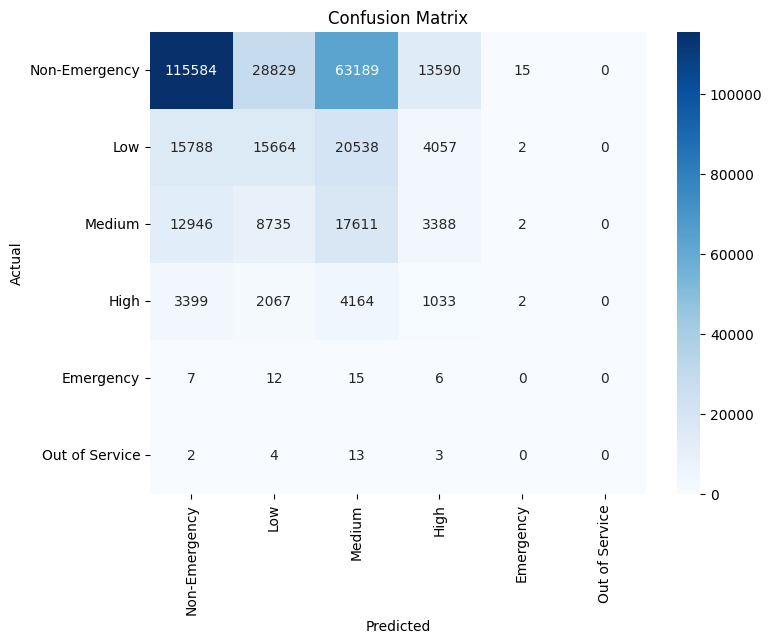

In [9]:
# Plot and generate the confusion matrix
y_true = Y_test
y_pred = preds.numpy()

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_priority.classes_, 
            yticklabels=le_priority.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix_no_description.png', dpi=300, bbox_inches='tight') 
plt.show()